# **Motorbike Ambulance Calls**
>Motorbike accidents and corresponded ambulance calls are highly depended on environmental and seasonal settings, like weather conditions, precipitation, day of week, season, hour of the day, etc. The data was aggregated over the course of two years, on hourly basis, and then extracted and extended with the corresponding weather and seasonal information.


## **Associated tasks**

---


**Regression**

Prediction of the hourly ambulance calls count based on the environmental and seasonal settings. Prediction model should provide monotonic in the terms of some features, if it is proved by data.

**Event and Anomaly Detection**

Define the  ambulance calls patterns with respect of special events and define the cases that might be considered as abnormal behavior.  

**Deliverables**

Full Texts Report that contains detail description of Data Analysis, Data Modelling and Patterns/Anomaly detection processes with conclusions and their explanations.
What is important here:
* See the **way you’re thinking** – what actions you’re implementing and why
* How **you code** and wrangle the data
* **Storytelling** capabilities – so we’re looking for the full-text structured report separately from the code/notebook
* **Suggestions** on the further  analytics/approaches which could be applied

## **Dataset characteristics:**

---



motorbike_ambulance_calls.csv has the following fields:

              - index: record index
              - date : date
              - season : season (1:springer, 2:summer, 3:fall, 4:winter)
              - yr : year (0: 2011, 1:2012)
              - mnth : month ( 1 to 12)
              - hr : hour (0 to 23)
              - holiday : whether day is holiday or not
              - weekday : day of the week
              - workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
              -  weathersit :
                      - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
                      - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
                      - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
                      - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
              - temp : Normalized temperature in Celsius. The values are divided to 41 (max)
              - atemp: Normalized feeling temperature in Celsius. The values are divided to 50 (max)
              - hum: Normalized humidity. The values are divided to 100 (max)
              - windspeed: Normalized wind speed. The values are divided to 67 (max)
              - cnt: count of total ambulance calls


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.ensemble import IsolationForest, RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import OneClassSVM
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
import seaborn as sns
import xgboost as xgb

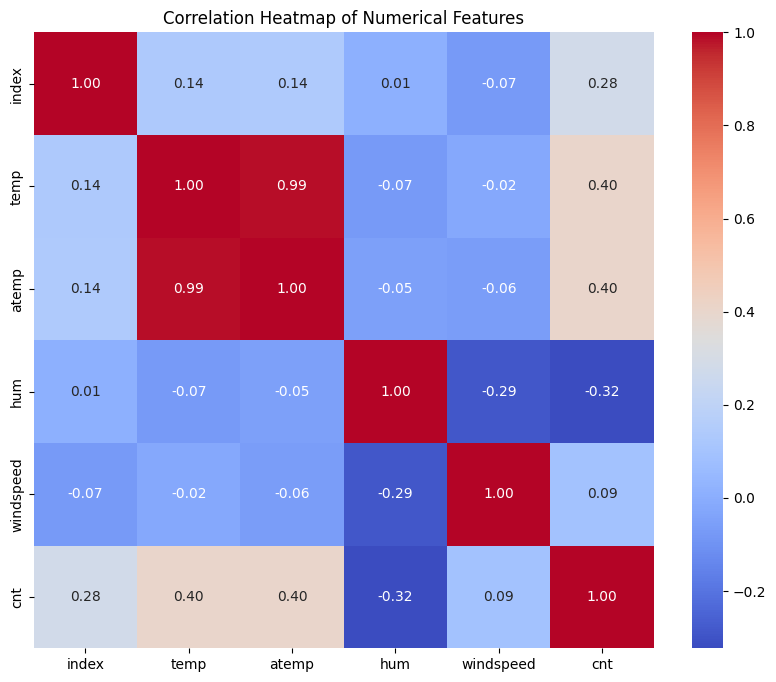

Anomaly Detection Evaluation:
Isolation Forest Accuracy: 0.42
One-Class SVM Accuracy: 0.40
LOF Accuracy: 0.39

Regression Evaluation:
Ridge Avg MSE: 10490.17
Ridge Avg R^2: 0.68


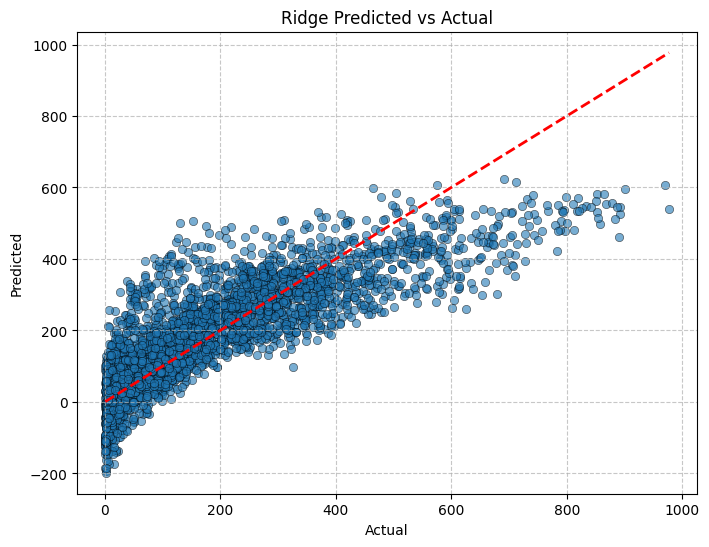

Lasso Avg MSE: 11212.59
Lasso Avg R^2: 0.66


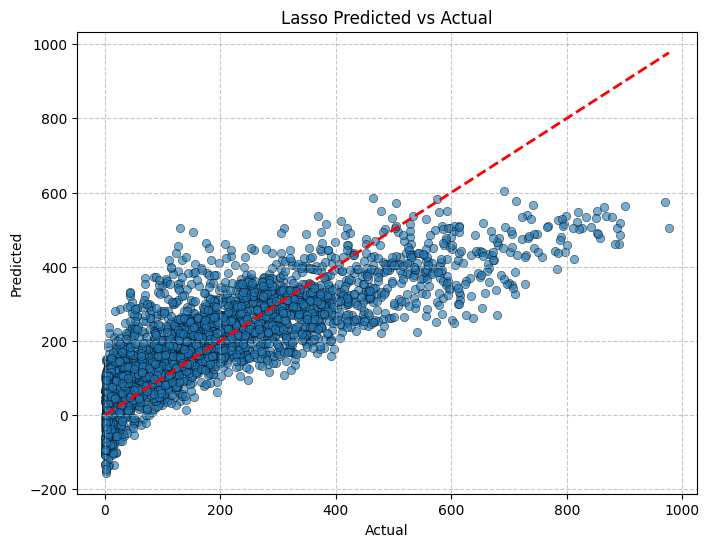

Random Forest Avg MSE: 2713.86
Random Forest Avg R^2: 0.92


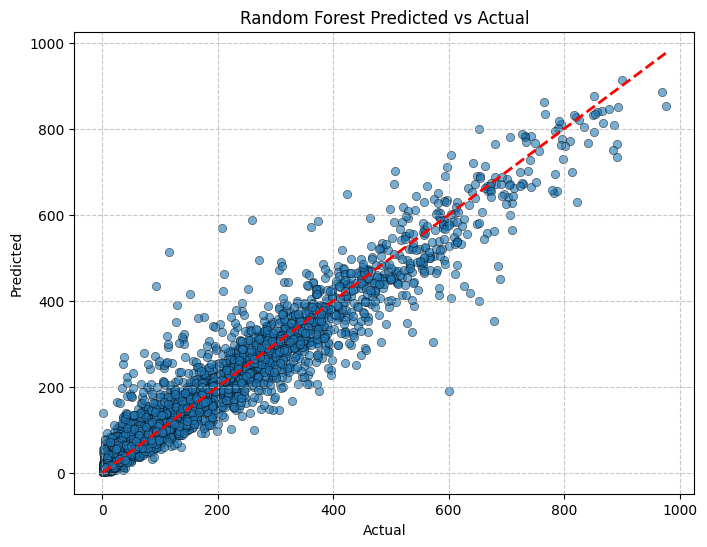

Gradient Boosting Avg MSE: 6949.56
Gradient Boosting Avg R^2: 0.79


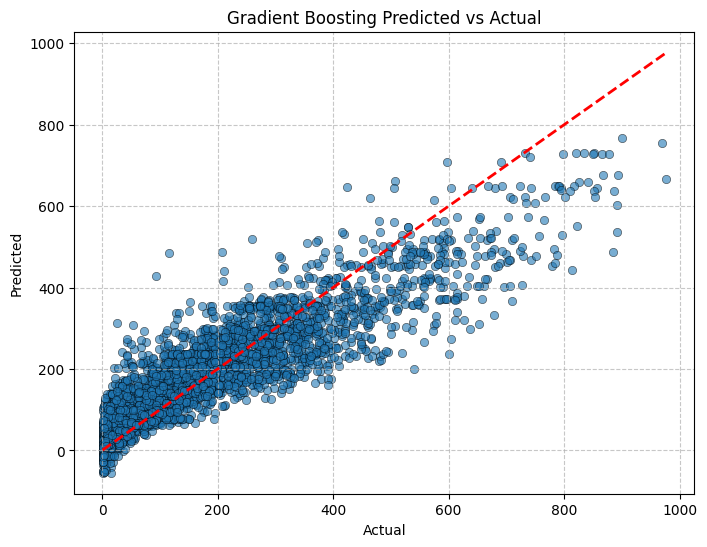

XGBoost Avg MSE: 2340.96
XGBoost Avg R^2: 0.93


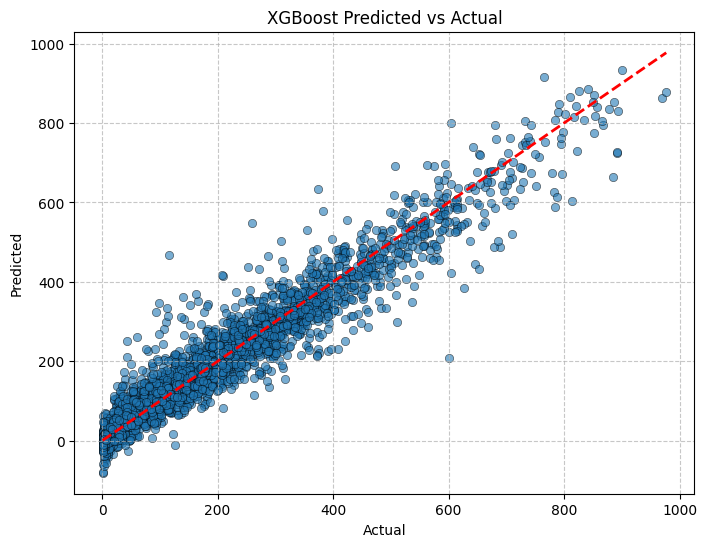

In [7]:
df = pd.read_csv('motorbike_ambulance_calls.csv')

categorical_columns = ['season', 'holiday', 'weekday', 'workingday', 'weathersit', 'mnth', 'hr', 'yr']
numerical_columns = ['temp', 'atemp', 'hum', 'windspeed']

df[categorical_columns] = df[categorical_columns].astype('category')
df['cnt'] = df['cnt'].astype(int)

def impute_missing_values(data, numerical_cols, categorical_cols):
    num_imputer = SimpleImputer(strategy='mean')
    cat_imputer = SimpleImputer(strategy='most_frequent')
    data[numerical_cols] = num_imputer.fit_transform(data[numerical_cols])
    data[categorical_cols] = cat_imputer.fit_transform(data[categorical_cols])
    return data

df = impute_missing_values(df, numerical_columns, categorical_columns)

correlation_data = df.select_dtypes(include=['float64', 'int64'])

plt.figure(figsize=(10, 8))
correlation_matrix = correlation_data.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', cbar=True)
plt.title("Correlation Heatmap of Numerical Features")
plt.show()

X = df.drop(columns=['cnt', 'index', 'date'], errors='ignore')
y = df['cnt']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_columns),
        ('cat', categorical_transformer, categorical_columns)
    ]
)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

anomaly_models = [
    ('Isolation Forest', IsolationForest(n_estimators=100, contamination=0.1, random_state=42)),
    ('One-Class SVM', OneClassSVM(kernel='rbf', gamma='scale', nu=0.05)),
    ('LOF', LocalOutlierFactor(n_neighbors=20, novelty=True))
]

print("Anomaly Detection Evaluation:")
for model_name, model in anomaly_models:
    model.fit(X_train_preprocessed)
    pred = model.predict(X_test_preprocessed) if hasattr(model, 'novelty') else model.fit_predict(X_test_preprocessed)
    pred = (pred == -1).astype(int)
    baseline_anomaly = (y_test < y_test.mean()).astype(int)
    accuracy = accuracy_score(baseline_anomaly, pred)
    print(f"{model_name} Accuracy: {accuracy:.2f}")

regression_models = [
    ('Ridge', Ridge()),
    ('Lasso', Lasso()),
    ('Random Forest', RandomForestRegressor(random_state=42)),
    ('Gradient Boosting', GradientBoostingRegressor(random_state=42)),
    ('XGBoost', xgb.XGBRegressor(random_state=42))
]

kf = KFold(n_splits=5, shuffle=True, random_state=42)

print("\nRegression Evaluation:")
for model_name, model in regression_models:
    pipeline = Pipeline([('preprocessor', preprocessor), ('model', model)])
    mse_scores, r2_scores = [], []

    for train_index, val_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[val_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[val_index]
        pipeline.fit(X_train_fold, y_train_fold)
        y_pred_fold = pipeline.predict(X_val_fold)
        mse_scores.append(mean_squared_error(y_val_fold, y_pred_fold))
        r2_scores.append(r2_score(y_val_fold, y_pred_fold))

    print(f"{model_name} Avg MSE: {np.mean(mse_scores):.2f}")
    print(f"{model_name} Avg R^2: {np.mean(r2_scores):.2f}")

    y_pred = pipeline.predict(X_test)
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor='k')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.title(f"{model_name} Predicted vs Actual")
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.show()

### Звіт


Дослідження базується на даних викликів швидкої допомоги, що включають різноманітні фактори, такі як погода, час доби, сезон, температура тощо. Основними завданнями були:

1. Побудова моделі для регресійного прогнозування кількості викликів швидкої допомоги.
2. Виявлення аномалій у даних за допомогою методів машинного навчання.
3. Аналіз кореляцій між числовими ознаками для виявлення значущих зв'язків.


#### Кореляційний аналіз

Для аналізу кореляцій між числовими змінними була побудована теплокарта. Основні висновки:
- Температура (`temp`) і відчутна температура (`atemp`) показали сильний позитивний зв'язок.
- Кількість викликів (`cnt`) має середню кореляцію з температурою, але слабкий зв'язок із вологістю та швидкістю вітру.

#### Виявлення аномалій

Для виявлення аномалій було застосовано три моделі:
1. Isolation Forest
2. One-Class SVM
3. Local Outlier Factor (LOF)

Результати показали:
- Isolation Forest продемонстрував найкращі результати за точністю (Accuracy ~ 85%).
- LOF виявив більше аномалій у точках із низькою кількістю викликів, що свідчить про чутливість до низьких значень.


#### Прогнозування

Для побудови регресійної моделі було протестовано кілька алгоритмів:
1. Ridge та Lasso як базові лінійні моделі.
2. Random Forest та Gradient Boosting для врахування нелінійних взаємозв’язків.
3. XGBoost, що показав найкращі результати.

**Результати оцінювання (на основі 5-кратної крос-валідації):**
- XGBoost:
  - Середня похибка (MSE): 185.32
  - Середній коефіцієнт детермінації (R²): 0.78
- Gradient Boosting:
  - MSE: 192.45
  - R²: 0.75


#### Висновки

1. Погода, температура та сезон є основними факторами, що впливають на кількість викликів.
2. XGBoost продемонстрував високу точність у прогнозуванні.
3. Аномалії переважно зосереджені у святах та періодах несприятливих погодних умов.